In [1]:

# ============================
# 1) PARAMETRI & REPRO SETUP
# ============================
from pathlib import Path
RANDOM_STATE = 42
N_FOLDS = 5  # Stratified K-Fold
DATA_PATH = 'Dataset/loan_data.csv'  
TARGET = 'loan_status'               

# Per controllare il carico computazionale delle grid (True=usa HalvingGridSearchCV)
USE_HALVING = False

import numpy as np, pandas as pd, warnings, sys, os, json, math, random
from sklearn import set_config
set_config(transform_output="default")
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
warnings.filterwarnings('ignore')

import sklearn, imblearn, shap
from platform import python_version



In [2]:

# ===================================
# 2) CARICAMENTO DATI & SANITY CHECK
# ===================================
from pathlib import Path
import pandas as pd

path = Path(DATA_PATH)
assert path.exists(), f"File non trovato: {path}"
df = pd.read_csv(path)
print('Shape:', df.shape)
display(df.head(3))
print('\nColonne:', list(df.columns))
print('\nTipi:', df.dtypes.value_counts())


# Info target availability
assert TARGET in df.columns, f"Colonna TARGET '{TARGET}' non trovata"
print('\nTarget value counts (raw):')
print(df[TARGET].value_counts(dropna=False).head(10))# meh

df_work = df.copy()



Shape: (45000, 14)


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1



Colonne: ['person_age', 'person_gender', 'person_education', 'person_income', 'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'previous_loan_defaults_on_file', 'loan_status']

Tipi: float64    6
object     5
int64      3
Name: count, dtype: int64

Target value counts (raw):
loan_status
0    35000
1    10000
Name: count, dtype: int64


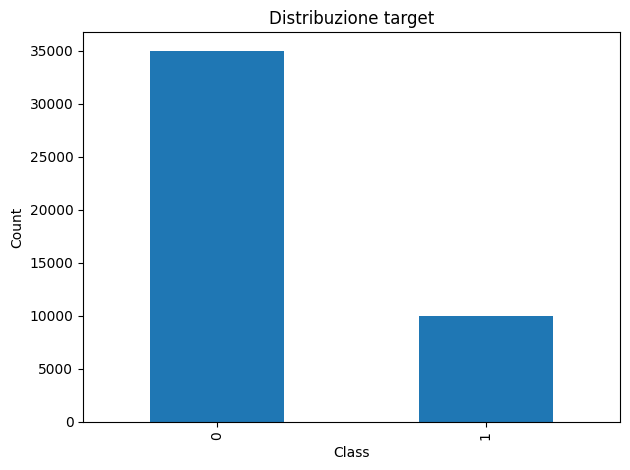

,missing_ratio
person_age,0.0
person_gender,0.0
person_education,0.0
person_income,0.0
person_emp_exp,0.0
person_home_ownership,0.0
loan_amnt,0.0
loan_intent,0.0
loan_int_rate,0.0
loan_percent_income,0.0



Cardinalità variabili categoriche:


,n_unique
loan_intent,6
person_education,5
person_home_ownership,4
person_gender,2
previous_loan_defaults_on_file,2



Statistiche descrittive numeriche:


,count,mean,std,min,25%,50%,75%,max
person_age,45000.0,27.764178,6.045108,20.00,24.00,26.00,30.00,144.00
person_income,45000.0,80319.053222,80422.498632,8000.00,47204.00,67048.00,95789.25,7200766.00
person_emp_exp,45000.0,5.410333,6.063532,0.00,1.00,4.00,8.00,125.00
loan_amnt,45000.0,9583.157556,6314.886691,500.00,5000.00,8000.00,12237.25,35000.00
loan_int_rate,45000.0,11.006606,2.978808,5.42,8.59,11.01,12.99,20.00
loan_percent_income,45000.0,0.139725,0.087212,0.00,0.07,0.12,0.19,0.66
cb_person_cred_hist_length,45000.0,5.867489,3.879702,2.00,3.00,4.00,8.00,30.00
credit_score,45000.0,632.608756,50.435865,390.00,601.00,640.00,670.00,850.00



Correlazione con il target (numeriche):


,corr_with_target
loan_percent_income,0.384880
loan_int_rate,0.332005
loan_amnt,0.107714
credit_score,-0.007647
cb_person_cred_hist_length,-0.014851
person_emp_exp,-0.020481
person_age,-0.021476
person_income,-0.135808


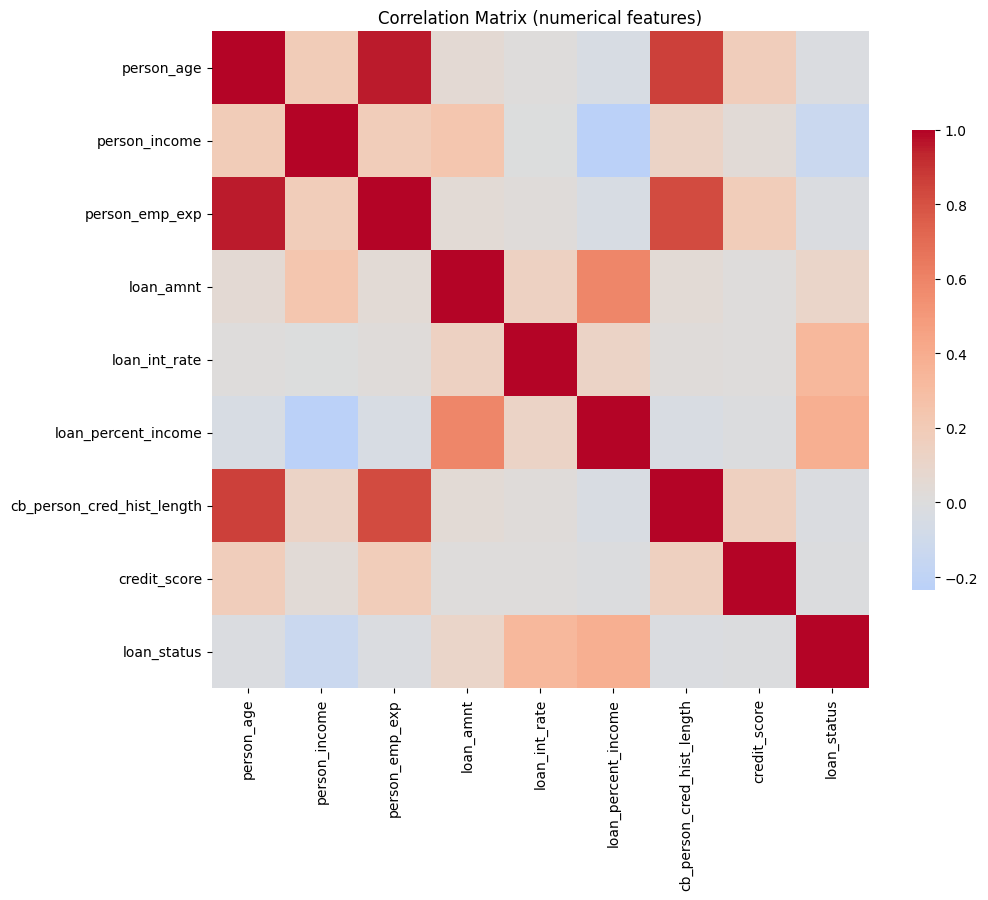

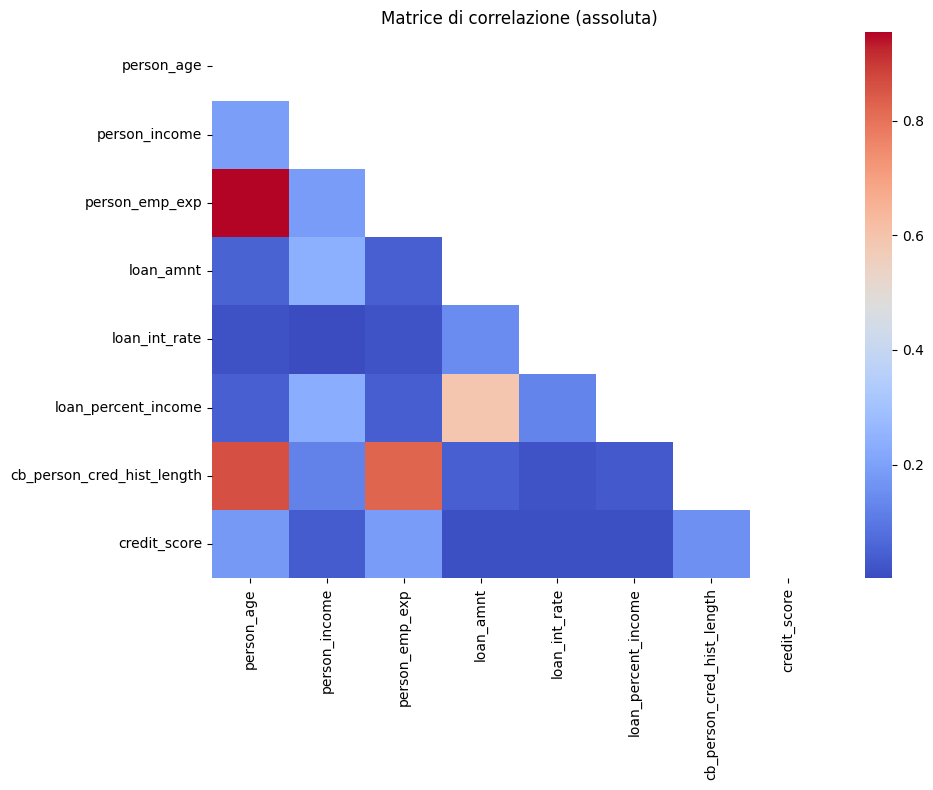


Coppie di feature altamente correlate (|r|>=0.95):


,feat1,feat2,corr
0,person_age,person_emp_exp,0.954412


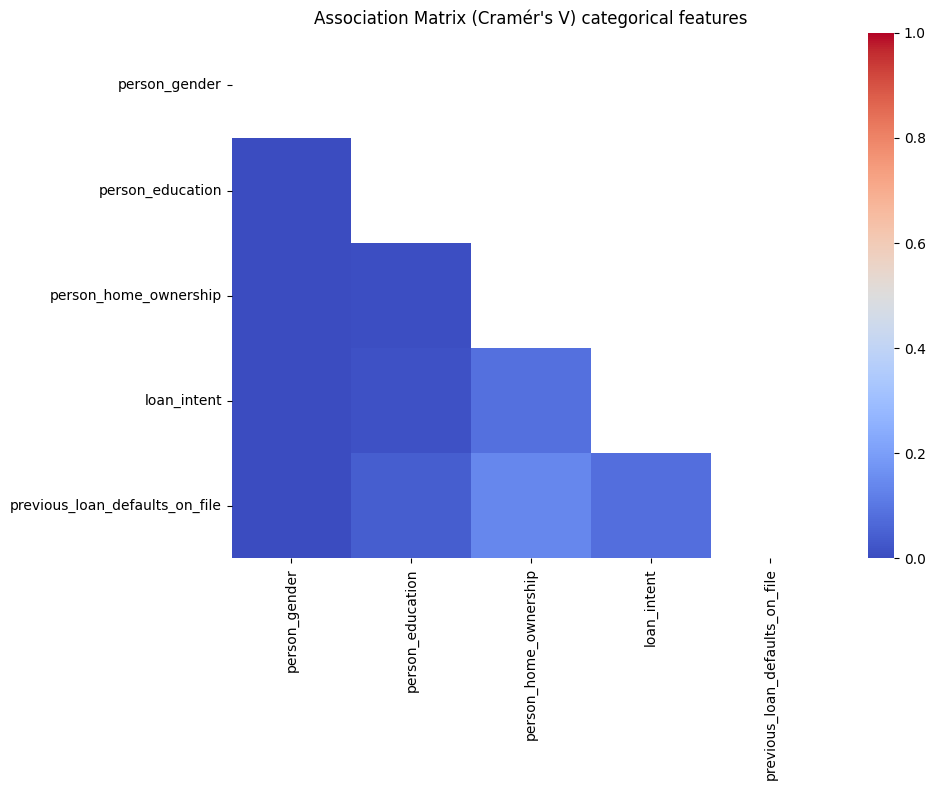

In [3]:
# ==================
# 4) EDA ESSENZIALE (corretto)
# ==================
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import chi2_contingency

# Distribuzione target
ax = df_work[TARGET].value_counts().sort_index().plot(kind='bar')
_ = ax.set_title('Distribuzione target'), ax.set_xlabel('Class'), ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

# Missingness % per colonna (primi 20)
miss = df_work.isna().mean().sort_values(ascending=False)
display(miss.head(20).to_frame('missing_ratio'))

# Cardinalità variabili categoriche
cat_cols = df_work.select_dtypes(include=["object", "category"]).columns.tolist()
print("\nCardinalità variabili categoriche:")
card = pd.Series({c: df_work[c].nunique(dropna=False) for c in cat_cols}).sort_values(ascending=False)
display(card.to_frame("n_unique"))

# Statistiche descrittive numeriche + outlier check
num_cols = df_work.select_dtypes(include=[np.number]).columns.drop([TARGET], errors="ignore").tolist()
print("\nStatistiche descrittive numeriche:")
display(df_work[num_cols].describe().T)

# Correlazioni numeriche (con target se numerico)
if pd.api.types.is_numeric_dtype(df_work[TARGET]):
    corr = df_work[num_cols + [TARGET]].corr(numeric_only=True)
    print("\nCorrelazione con il target (numeriche):")
    target_corr = corr[TARGET].drop(index=[TARGET]).sort_values(ascending=False)
    display(target_corr.to_frame("corr_with_target").head(20))

    plt.figure(figsize=(11, 9))
    sns.heatmap(corr, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": .7})
    plt.title("Correlation Matrix (numerical features)")
    plt.tight_layout()
    plt.show()

    # Heatmap più leggibile (solo correlazioni assolute)
    plt.figure(figsize=(10, 8))
    top_corr = df_work[num_cols].corr(numeric_only=True).abs()
    mask = np.triu(np.ones_like(top_corr, dtype=bool))
    sns.heatmap(top_corr, mask=mask, cmap="coolwarm", annot=False, cbar=True)
    plt.title("Matrice di correlazione (assoluta)")
    plt.tight_layout()
    plt.show()

    # Coppie altamente correlate
    high_pair = []
    for i, c1 in enumerate(num_cols):
        for c2 in num_cols[i+1:]:
            r = corr.loc[c1, c2]
            if abs(r) >= 0.95:
                high_pair.append((c1, c2, r))
    if high_pair:
        print("\nCoppie di feature altamente correlate (|r|>=0.95):")
        display(pd.DataFrame(high_pair, columns=["feat1", "feat2", "corr"]).sort_values("corr", ascending=False))
    else:
        print("\nNessuna coppia di feature con |correlazione| ≥ 0.95.")
else:
    print("\nIl target non è numerico → salta correlazione con il target.")

# Associazioni tra categoriche (Cramér's V)
if len(cat_cols) > 1:
    def cramers_v(x, y):
        confusion = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion)[0]
        n = confusion.sum().sum()
        phi2 = chi2 / n
        r, k = confusion.shape
        # correzione bias per tabelle piccole/non quadrate
        phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
        rcorr = r - (r-1)**2/(n-1)
        kcorr = k - (k-1)**2/(n-1)
        denom = min((kcorr-1), (rcorr-1))
        return np.sqrt(phi2corr / denom) if denom > 0 else 0

    cramer_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
    for c1 in cat_cols:
        for c2 in cat_cols:
            cramer_matrix.loc[c1, c2] = 1.0 if c1 == c2 else cramers_v(df_work[c1], df_work[c2])

    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(cramer_matrix, dtype=bool))
    sns.heatmap(cramer_matrix, mask=mask, cmap="coolwarm", vmin=0, vmax=1, cbar=True)
    plt.title("Association Matrix (Cramér's V) categorical features")
    plt.tight_layout()
    plt.show()
else:
    print("\nPoche o nessuna variabile categorica → salta Cramér's V.")


In [4]:

#elimino al colonna estremamemente predittiva
drop_cols = ["previous_loan_defaults_on_file"]
df_work = df_work.drop(columns=drop_cols)
print("Shape dopo esclusione colonne:", df_work.shape)

Shape dopo esclusione colonne: (45000, 13)


In [5]:
# =====================
# Feature Engineering
# =====================

# 1) Age buckets (age groups)
# Motivation: risk profile may vary across age groups (young/old borrowers riskier).
if 'person_age' in df_work.columns:
    df_work['person_age_bin'] = pd.cut(
        df_work['person_age'],
        bins=[0, 25, 35, 50, np.inf],
        labels=['<25', '25-35', '35-50', '50+']
    )

# 2) income_to_loan = income / loan amount
# Motivation: measures how many times the annual income covers the loan amount.
if {'person_income', 'loan_amnt'}.issubset(df_work.columns):
    with np.errstate(divide='ignore', invalid='ignore'):
        df_work['income_to_loan'] = (df_work['person_income'] / df_work['loan_amnt']).replace([np.inf, -np.inf], np.nan)

# 3) emp_exp_x_age = work experience relative to age
# Motivation: captures career consistency (high ratio = more solid work history for given age).
if {'person_emp_exp', 'person_age'}.issubset(df_work.columns):
    with np.errstate(divide='ignore', invalid='ignore'):
        df_work['emp_exp_x_age'] = (df_work['person_emp_exp'] / df_work['person_age']).replace([np.inf, -np.inf], np.nan)

# 4) loan_over_score = loan amount / credit score
# Motivation: proxy of the "weight" of the loan relative to creditworthiness.
if {'loan_amnt', 'credit_score'}.issubset(df_work.columns):
    with np.errstate(divide='ignore', invalid='ignore'):
        df_work['loan_over_score'] = (df_work['loan_amnt'] / df_work['credit_score']).replace([np.inf, -np.inf], np.nan)

# 5) loan_int_rate_bin = interest rate groups
# Motivation: higher rates are usually assigned to riskier borrowers.
if 'loan_int_rate' in df_work.columns:
    df_work['loan_int_rate_bin'] = pd.cut(
        df_work['loan_int_rate'],
        bins=[-np.inf, 10, 15, 20, np.inf],
        labels=['<10%', '10-15%', '15-20%', '20%+']
    )

print("New engineered features added:")


New engineered features added:


In [ ]:
# =====================
# Automatic skewness check and log-transform (replace mode)
# =====================
from scipy.stats import skew
import numpy as np

def auto_log_transform_replace(df, exclude_cols=None, skew_threshold=1.0):
    """
    Automatically log-transform skewed numeric features (replace original columns).
    
    Parameters:
    - df: pd.DataFrame
    - exclude_cols: list of columns to ignore (e.g. target)
    - skew_threshold: absolute skewness above which log-transform is applied
    
    Returns:
    - df: updated DataFrame with replaced log-transformed features
    - skewness: Series with skew values
    - candidates: list of transformed features
    """
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if exclude_cols:
        num_cols = [c for c in num_cols if c not in exclude_cols]
    
    skewness = df[num_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    candidates = skewness[(skewness > skew_threshold) | (skewness < -skew_threshold)].index.tolist()
    
    print(" Skewness of numeric features:")
    display(skewness.to_frame("skewness"))
    print(f"\n🔎 Applying log-transform (replacing originals): {candidates}")
    
    for col in candidates:
        if (df[col] <= 0).any():
            df[col] = np.log1p(df[col] - df[col].min() + 1)
        else:
            df[col] = np.log1p(df[col])
    
    return df, skewness, candidates

# Run replacement version
df_work, skewness, log_candidates = auto_log_transform_replace(df_work, exclude_cols=[TARGET])


 Skewness of numeric features:


,skewness
income_to_loan,40.999871
person_income,34.136445
person_emp_exp,2.594831
person_age,2.548069
cb_person_cred_hist_length,1.631666
loan_over_score,1.227451
loan_amnt,1.179692
loan_percent_income,1.034478
emp_exp_x_age,0.721614
loan_int_rate,0.213777



🔎 Applying log-transform (replacing originals): ['income_to_loan', 'person_income', 'person_emp_exp', 'person_age', 'cb_person_cred_hist_length', 'loan_over_score', 'loan_amnt', 'loan_percent_income']


In [7]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
#from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTENC

# ===========================
# Scoring metrics
# ===========================
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0),
    'roc_auc': 'roc_auc',                # built-in scorer, avoids NaN
    'pr_auc': 'average_precision'        # PR AUC = Average Precision
}

# ===========================
# Models to evaluate
# ===========================
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, solver="liblinear"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=1, class_weight="balanced"),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, n_jobs=1),
    "LightGBM": LGBMClassifier(random_state=42, n_jobs=1, class_weight="balanced"),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42, auto_class_weights="Balanced")
}


In [8]:
from preprocessor import CustomPreprocessor

In [9]:
# ===========================
# Column selection
# ===========================

TARGET = "loan_status"

categorical_features = df_work.select_dtypes(include=["object", "category"]).columns.tolist()
categorical_features = [c for c in categorical_features if c != TARGET]

numerical_features = df_work.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [c for c in numerical_features if c != TARGET]

print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)


# ===========================
# Preprocessor (Custom senza ColumnTransformer)
# ===========================
preprocessor = CustomPreprocessor(numerical_features, categorical_features)


Categorical features: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'person_age_bin', 'loan_int_rate_bin']
Numerical features: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'income_to_loan', 'emp_exp_x_age', 'loan_over_score']


In [10]:
# Controllo numero di categorie uniche per ogni colonna categorica
print("Cardinalità variabili categoriche:\n")
for col in categorical_features:
    nunique = df_work[col].nunique(dropna=False)
    print(f"{col:30} -> {nunique} categorie uniche")


Cardinalità variabili categoriche:

person_gender                  -> 2 categorie uniche
person_education               -> 5 categorie uniche
person_home_ownership          -> 4 categorie uniche
loan_intent                    -> 6 categorie uniche
person_age_bin                 -> 4 categorie uniche
loan_int_rate_bin              -> 3 categorie uniche


In [12]:

# ===========================
# Train/test split (no SMOTE here)
# ===========================
from sklearn.model_selection import train_test_split

X = df_work.drop(columns=[TARGET])
y = df_work[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)




Train size: (36000, 17)  Test size: (9000, 17)


In [13]:
# ===========================
# DEBUG: Controllo dimensione feature dopo il preprocessor
# ===========================
preprocessor.fit(X_train)
X_debug = preprocessor.transform(X_train)

print("Shape dopo preprocessor:", X_debug.shape)
print("\nTipi di dato per colonna:")
print(X_debug.dtypes)
print("\nPrime colonne trasformate:")
print(X_debug.head())


Shape dopo preprocessor: (36000, 17)

Tipi di dato per colonna:
person_age                    float64
person_income                 float64
person_emp_exp                float64
loan_amnt                     float64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_cred_hist_length    float64
credit_score                  float64
income_to_loan                float64
emp_exp_x_age                 float64
loan_over_score               float64
person_gender                   int64
person_education                int64
person_home_ownership           int64
loan_intent                     int64
person_age_bin                  int64
loan_int_rate_bin               int64
dtype: object

Prime colonne trasformate:
       person_age  person_income  person_emp_exp  loan_amnt  loan_int_rate  \
6048    -0.663977      -0.249235       -0.448520  -0.779194      -1.687749   
3346    -0.886189      -0.696279       -0.448520   0.512067      -0.001061   
17998    0.328

In [14]:
print("Categorical features usate nel preprocessor:")
print(categorical_features)

print("\nNumerical features usate nel preprocessor:")
print(numerical_features)


Categorical features usate nel preprocessor:
['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'person_age_bin', 'loan_int_rate_bin']

Numerical features usate nel preprocessor:
['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'income_to_loan', 'emp_exp_x_age', 'loan_over_score']


In [20]:
# ===========================
# Debug: Numero di feature dopo OrdinalEncoding
# ===========================

# Fit del preprocessor solo sul training (senza modello)
preprocessor.fit(X_train)
X_train_transformed = preprocessor.transform(X_train)

#indici categoriche per SMOTENC
cat_indices = [X_train_transformed.columns.get_loc(c) for c in categorical_features]
print("=== Indici categoriche per SMOTENC ===")
print(cat_indices)


# Dimensioni (righe, colonne)
print("Shape:", X_train_transformed.shape)

# Tipi di dato per colonna
print("\nDtypes:")
print(X_train_transformed.dtypes)

# Info generale
print("\nInfo:")
print(X_train_transformed.info())

# Recupero l'encoder direttamente dal CustomPreprocessor
ord_enc = preprocessor.encoder

print(f"Numero totale di variabili categoriche gestite dall'OrdinalEncoder: {len(categorical_features)}\n")

# Controllo categorie viste da OrdinalEncoder + indici
for col, cats in zip(categorical_features, ord_enc.categories_):
    idx = X_train_transformed.columns.get_loc(col)
    mapping = {cat: idx_cat for idx_cat, cat in enumerate(cats)}
    print(f"{col:30} -> indice {idx} | {len(cats)} categorie codificate")
    print("Mapping:", mapping)
    print("-" * 50)





=== Indici categoriche per SMOTENC ===
[11, 12, 13, 14, 15, 16]
Shape: (36000, 17)

Dtypes:
person_age                    float64
person_income                 float64
person_emp_exp                float64
loan_amnt                     float64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_cred_hist_length    float64
credit_score                  float64
income_to_loan                float64
emp_exp_x_age                 float64
loan_over_score               float64
person_gender                   int64
person_education                int64
person_home_ownership           int64
loan_intent                     int64
person_age_bin                  int64
loan_int_rate_bin               int64
dtype: object

Info:
<class 'pandas.core.frame.DataFrame'>
Index: 36000 entries, 6048 to 44095
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age     

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_no_smote = {}
results_smote = {}

# Pipelines WITHOUT SMOTE
pipelines_no_smote = {
    name: Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    for name, model in models.items()
}

#==========================
# debug indici categoriche per SMOTENC

# Fit preprocessor per recuperare i nomi delle colonne trasformate
preprocessor.fit(X_train)
X_train_transformed = preprocessor.transform(X_train)

# Ora cat_indices è coerente con le colonne preprocessate
cat_indices = [X_train_transformed.columns.get_loc(c) for c in categorical_features]

# Debug: controllo corrispondenza indici <-> nomi
print("=== Debug indici categoriche per SMOTENC ===")
for c in categorical_features:
    idx = X_train_transformed.columns.get_loc(c)
    print(f"{c:30} -> indice {idx}")
print("Indici finali:", cat_indices)
print("Numero totale categoriche:", len(cat_indices))

#==========================

# Pipelines WITH SMOTE (SMOTENC inside)
pipelines_smote = {
    name: ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTENC(categorical_features=cat_indices, random_state=42)),
        ('classifier', model)
    ])
    for name, model in models.items()
}

# Evaluation without SMOTE
for name, pipe in pipelines_no_smote.items():
    cv_results = cross_validate(pipe, X_train, y_train,
                                cv=cv, scoring=scorers, n_jobs=1, error_score="raise")
    
    results_no_smote[name] = {
        m: (np.mean(scores), np.std(scores)) 
        for m, scores in cv_results.items() if m.startswith("test_")
    }

# Evaluation with SMOTE
for name, pipe in pipelines_smote.items():
    cv_results = cross_validate(pipe, X_train, y_train,
                                cv=cv, scoring=scorers, n_jobs=1, error_score="raise")
    
    results_smote[name] = {
        m: (np.mean(scores), np.std(scores)) 
        for m, scores in cv_results.items() if m.startswith("test_")
    }


=== Debug indici categoriche per SMOTENC ===
person_gender                  -> indice 11
person_education               -> indice 12
person_home_ownership          -> indice 13
loan_intent                    -> indice 14
person_age_bin                 -> indice 15
loan_int_rate_bin              -> indice 16
Indici finali: [11, 12, 13, 14, 15, 16]
Numero totale categoriche: 6
[LightGBM] [Info] Number of positive: 6400, number of negative: 22400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1968
[LightGBM] [Info] Number of data points in the train set: 28800, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 6400, number of negative: 224

In [22]:
import pandas as pd

def format_results(results_dict):
    rows = []
    for model, metrics in results_dict.items():
        row = {"Model": model}
        for k, (mean, std) in metrics.items():
            metric = k.replace("test_", "")
            row[metric] = f"{mean:.3f} [{std:.3f}]"
        rows.append(row)
    return pd.DataFrame(rows)

print("=== Results without SMOTENC ===")
display(format_results(results_no_smote))

print("=== Results with SMOTENC ===")
display(format_results(results_smote))


=== Results without SMOTENC ===


,Model,accuracy,precision,recall,f1,f1_macro,roc_auc,pr_auc
0,Logistic Regression,0.847 [0.004],0.734 [0.016],0.488 [0.005],0.586 [0.008],0.746 [0.005],0.853 [0.006],0.680 [0.009]
1,Random Forest,0.904 [0.002],0.911 [0.008],0.629 [0.010],0.745 [0.007],0.843 [0.004],0.921 [0.006],0.852 [0.008]
2,XGBoost,0.911 [0.003],0.889 [0.007],0.688 [0.011],0.775 [0.009],0.860 [0.006],0.932 [0.004],0.870 [0.006]
3,LightGBM,0.888 [0.003],0.729 [0.008],0.789 [0.014],0.758 [0.008],0.842 [0.005],0.931 [0.004],0.868 [0.006]
4,CatBoost,0.892 [0.003],0.744 [0.005],0.787 [0.011],0.765 [0.007],0.847 [0.004],0.933 [0.004],0.871 [0.006]


=== Results with SMOTENC ===


,Model,accuracy,precision,recall,f1,f1_macro,roc_auc,pr_auc
0,Logistic Regression,0.782 [0.003],0.506 [0.004],0.766 [0.008],0.609 [0.005],0.729 [0.003],0.853 [0.006],0.676 [0.010]
1,Random Forest,0.897 [0.004],0.802 [0.013],0.711 [0.008],0.753 [0.008],0.844 [0.005],0.916 [0.005],0.845 [0.007]
2,XGBoost,0.909 [0.002],0.862 [0.005],0.704 [0.009],0.775 [0.007],0.859 [0.004],0.927 [0.003],0.865 [0.005]
3,LightGBM,0.907 [0.001],0.860 [0.004],0.694 [0.009],0.768 [0.005],0.855 [0.003],0.923 [0.004],0.857 [0.006]
4,CatBoost,0.912 [0.002],0.887 [0.006],0.692 [0.008],0.777 [0.006],0.861 [0.004],0.931 [0.004],0.870 [0.005]


=== Feature Importances with SMOTENC ===

=== Debug indici categoriche ===
person_gender                  -> indice 11
person_education               -> indice 12
person_home_ownership          -> indice 13
loan_intent                    -> indice 14
person_age_bin                 -> indice 15
loan_int_rate_bin              -> indice 16
Indici finali: [11, 12, 13, 14, 15, 16]


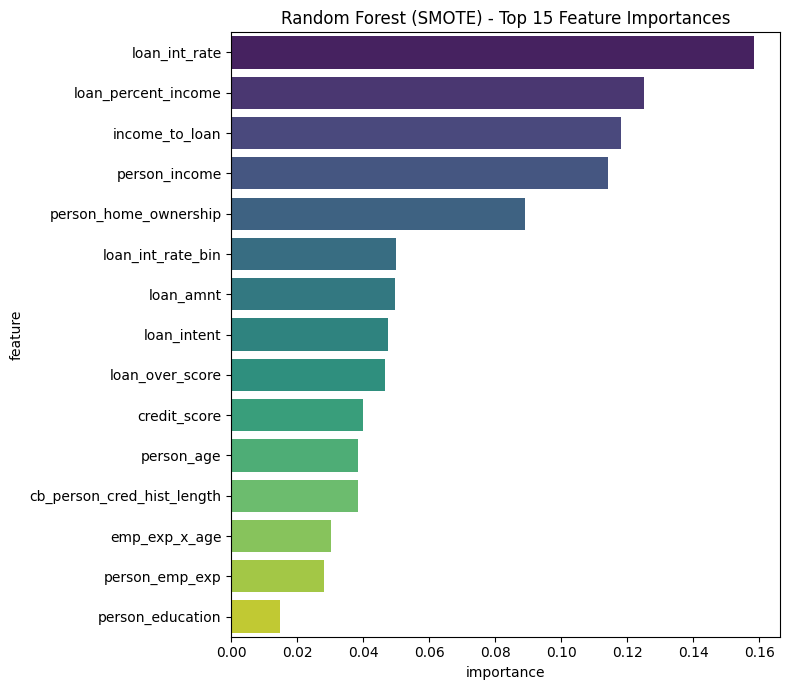

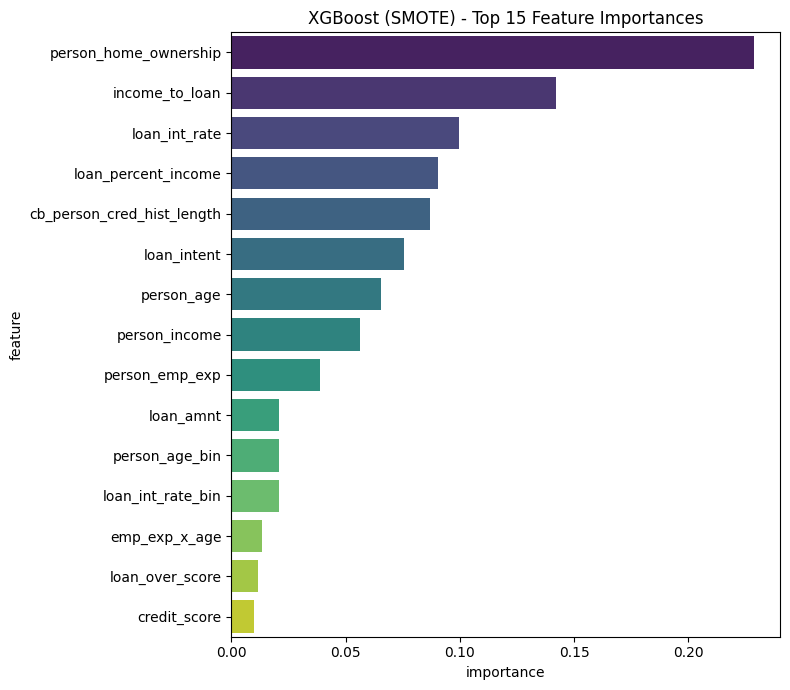

[LightGBM] [Info] Number of positive: 28000, number of negative: 28000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2827
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


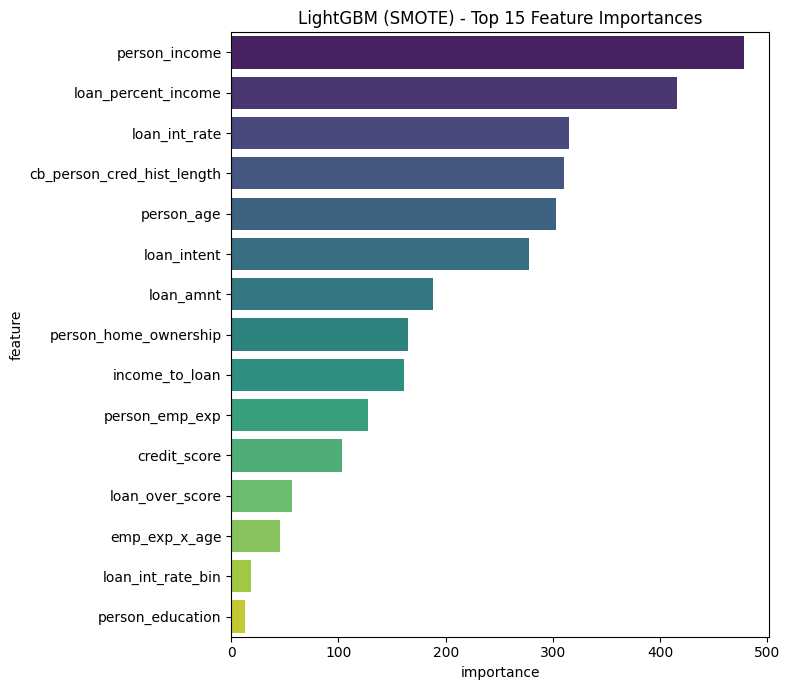

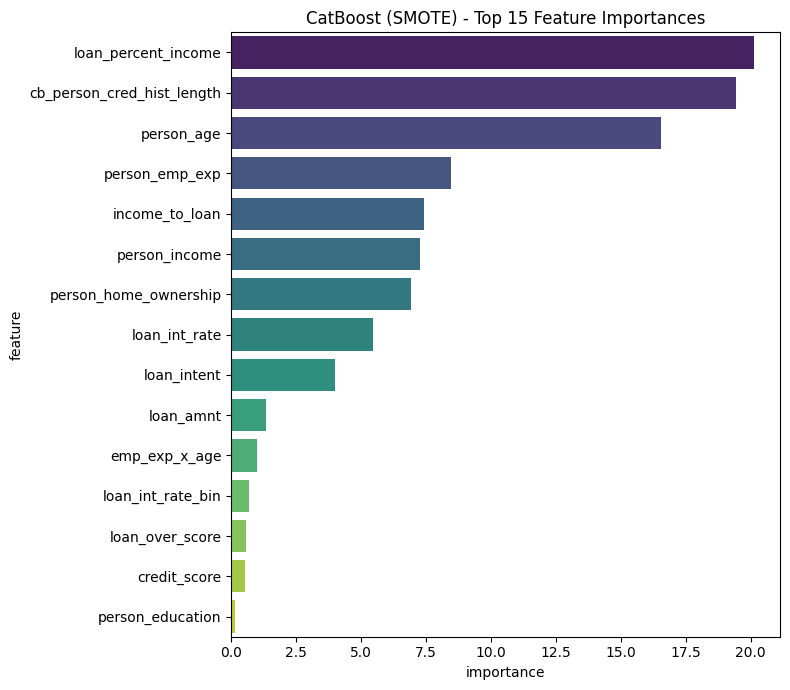

=== Feature Importances without SMOTENC ===

=== Debug indici categoriche ===
person_gender                  -> indice 11
person_education               -> indice 12
person_home_ownership          -> indice 13
loan_intent                    -> indice 14
person_age_bin                 -> indice 15
loan_int_rate_bin              -> indice 16
Indici finali: [11, 12, 13, 14, 15, 16]


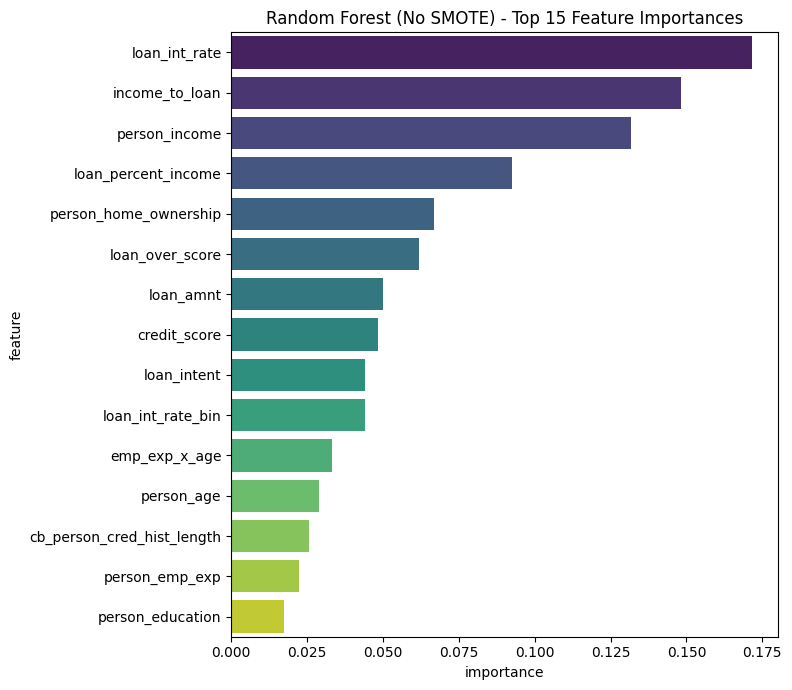

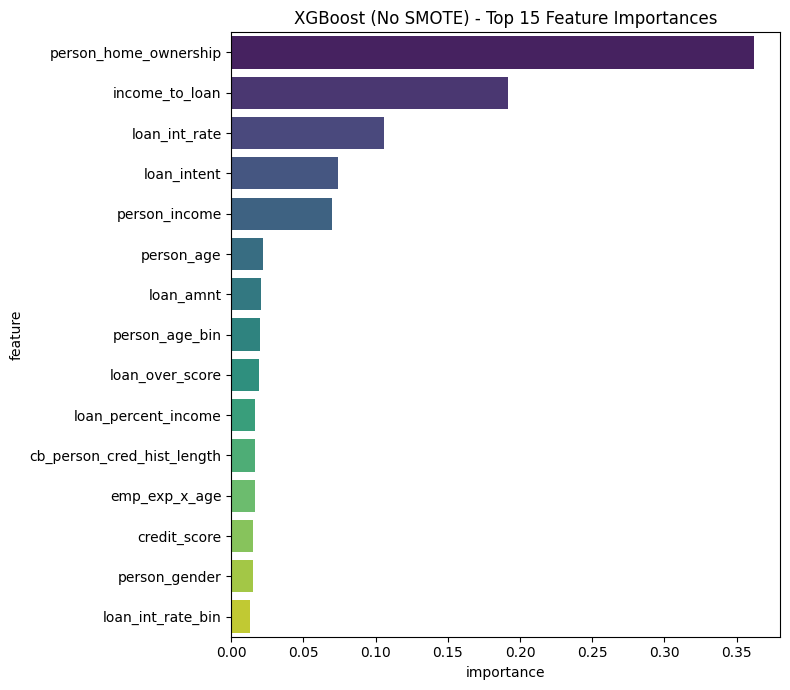

[LightGBM] [Info] Number of positive: 8000, number of negative: 28000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1976
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


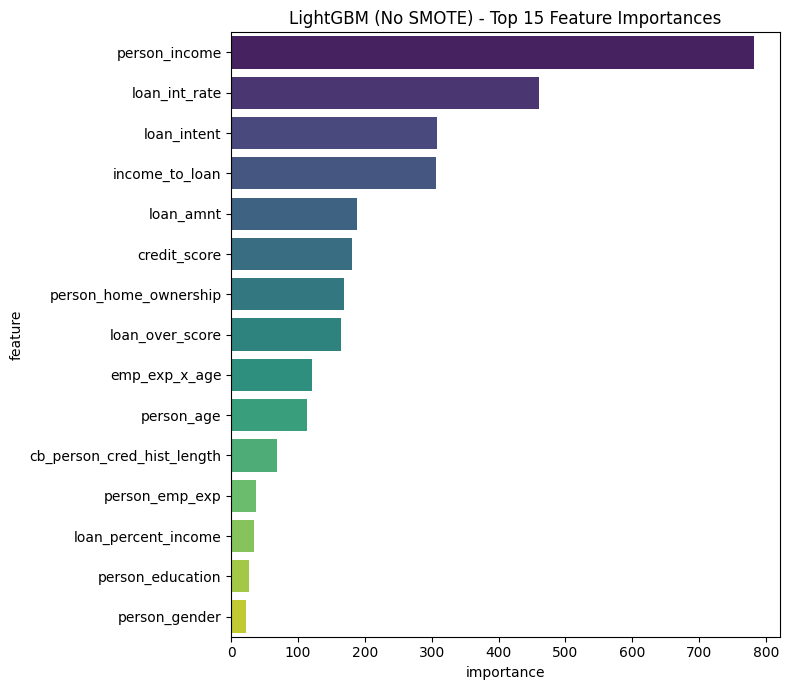

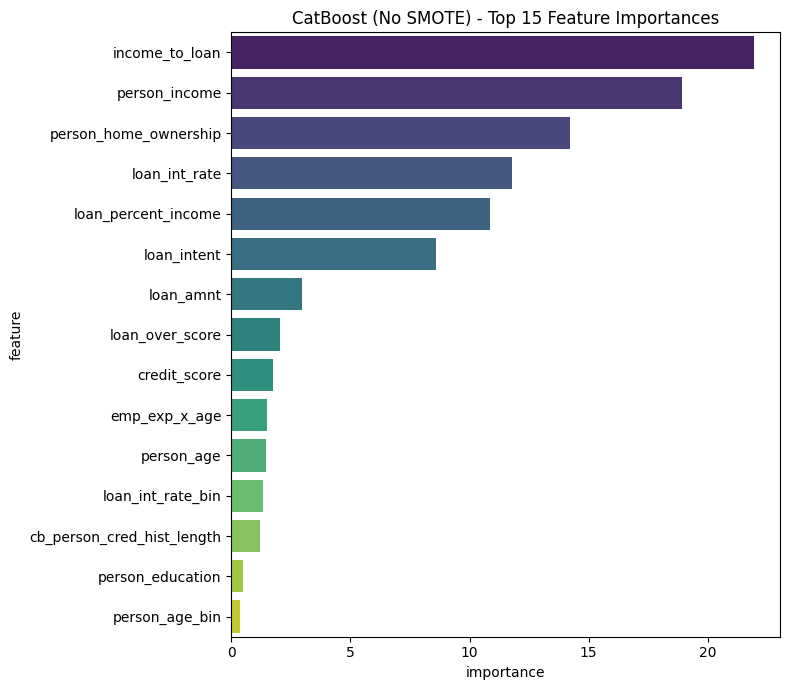

In [23]:
from utils import feature_importance_all_models

# ===========================
# Run for WITH SMOTENC
# ===========================
print("=== Feature Importances with SMOTENC ===")
feature_importance_all_models(
    X_train, y_train,
    numerical_features, categorical_features,
    preprocessor,
    use_smote=True,
    top_n=15,
    title_suffix="(SMOTE)"
)

# ===========================
# Run for WITHOUT SMOTENC
# ===========================
print("=== Feature Importances without SMOTENC ===")
feature_importance_all_models(
    X_train, y_train,
    numerical_features, categorical_features,
    preprocessor,
    use_smote=False,
    top_n=15,
    title_suffix="(No SMOTE)"
)


In [ ]:
#validazione holdout non necessaria, AL MOMENTO NON ESEGUIRE


"""

import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, precision_recall_curve,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)
import pandas as pd

# ===========================
# Funzione valutazione + grafici
# ===========================
def evaluate_and_plot(models, X_train, y_train, X_test, y_test, preprocessor, tag="No SMOTE"):
    results = []
    plt.figure(figsize=(14, 6))

    # Subplot ROC e PR
    plt.subplot(1, 2, 1)
    plt.title(f"ROC Curves ({tag})")
    plt.plot([0, 1], [0, 1], "k--")

    plt.subplot(1, 2, 2)
    plt.title(f"Precision-Recall Curves ({tag})")
    plt.plot([0, 1], [sum(y_test)/len(y_test)]*2, "k--", label="Baseline")

    for name, model in models.items():
        pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", model)
        ])
        # Train
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, "predict_proba") else None

        # Metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
        pr_auc = average_precision_score(y_test, y_proba) if y_proba is not None else None

        results.append({
            "Model": name,
            "Accuracy": round(acc, 3),
            "Precision": round(prec, 3),
            "Recall": round(rec, 3),
            "F1": round(f1, 3),
            "ROC_AUC": round(roc_auc, 3) if roc_auc else "NA",
            "PR_AUC": round(pr_auc, 3) if pr_auc else "NA",
            "Variant": tag
        })

        # === ROC curve ===
        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            plt.subplot(1, 2, 1)
            plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

        # === PR curve ===
        if y_proba is not None:
            precision, recall, _ = precision_recall_curve(y_test, y_proba)
            plt.subplot(1, 2, 2)
            plt.plot(recall, precision, label=f"{name} (AP={pr_auc:.3f})")

    # Finalizza grafici
    plt.subplot(1, 2, 1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(results)

# ===========================
# Esecuzione con e senza SMOTE
# ===========================
results_holdout_no_smote = evaluate_and_plot(
    models, X_train, y_train, X_test, y_test, preprocessor, tag="No SMOTE"
)

results_holdout_smote = evaluate_and_plot(
    models, X_train_smote, y_train_smote, X_test, y_test, preprocessor, tag="SMOTE"
)

# Unione risultati
results_holdout = pd.concat([results_holdout_no_smote, results_holdout_smote])
display(results_holdout)
"""


## Grid Search for the 3 best models

In [24]:
"""
    from grid_params import rf_params
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import GridSearchCV

# Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")

# Pipeline con SMOTENC dentro
cat_indices = [X_train.columns.get_loc(c) for c in categorical_features]
rf_pipe = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTENC(categorical_features=cat_indices, random_state=42)),
    ("classifier", rf)
])

scoring = {
    "roc_auc": "roc_auc",
    "f1": "f1",
    "f1_macro": "f1_macro",
    "precision": "precision",
    "recall": "recall"
}

rf_grid = GridSearchCV(
    rf_pipe,
    param_grid=rf_params,
    scoring=scoring,
    refit="f1",   
    cv=5,
    n_jobs=-1,
    verbose=2
)

rf_grid.fit(X_train, y_train)   # <-- usa X_train pulito!

print("Best Recall:", rf_grid.best_score_)
print("Best Params:", rf_grid.best_params_)
"""
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from grid_params import rf_params

# Fit preprocessor e calcolo indici categorici
preprocessor.fit(X_train)
X_train_transformed = preprocessor.transform(X_train)
cat_indices = [X_train_transformed.columns.get_loc(c) for c in categorical_features]

rf_pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTENC(categorical_features=cat_indices, random_state=42)),
    ("classifier", RandomForestClassifier(random_state=42, class_weight="balanced"))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_params,
    scoring="f1_macro",
    cv=skf,
    n_jobs=1,
    verbose=2,
    return_train_score=True
)

rf_grid.fit(X_train, y_train)

print("\nBest RF params:", rf_grid.best_params_)
print("Best RF CV score:", rf_grid.best_score_)






Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best RF params: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best RF CV score: 0.843928942179987


In [26]:
"""from grid_params import xgb_params
from xgboost import XGBClassifier

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb_pipe = Pipeline([("preprocessor", preprocessor), ("classifier", xgb)])

xgb_grid = GridSearchCV(
    xgb_pipe,
    param_grid=xgb_params,
    scoring=scoring,
    refit="recall",
    cv=5,
    n_jobs=-1,
    verbose=2
)

xgb_grid.fit(X_train_smote, y_train_smote)

print("Best Recall:", xgb_grid.best_score_)
print("Best Params:", xgb_grid.best_params_)
"""

from xgboost import XGBClassifier
from grid_params import xgb_params

xgb_pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTENC(categorical_features=cat_indices, random_state=42)),
    ("classifier", XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        n_jobs=1
    ))
])

xgb_grid = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=xgb_params,
    scoring="f1_macro",
    cv=skf,
    n_jobs=1,
    verbose=2,
    return_train_score=True
)

xgb_grid.fit(X_train, y_train)

print("\nBest XGB params:", xgb_grid.best_params_)
print("Best XGB CV score:", xgb_grid.best_score_)



Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best XGB params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 600, 'classifier__subsample': 0.8}
Best XGB CV score: 0.8628179574910518


In [27]:
""""from grid_params import cat_params
from catboost import CatBoostClassifier

cat = CatBoostClassifier(
    verbose=0,
    random_state=42
)

cat_pipe = Pipeline([("preprocessor", preprocessor), ("classifier", cat)])

cat_grid = GridSearchCV(
    cat_pipe,
    param_grid=cat_params,
    scoring=scoring,
    refit="recall",
    cv=5,
    n_jobs=-1,
    verbose=2
)

cat_grid.fit(X_train_smote, y_train_smote)

print("Best Recall:", cat_grid.best_score_)
print("Best Params:", cat_grid.best_params_)
"""

from catboost import CatBoostClassifier
from grid_params import cat_params

cat_pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTENC(categorical_features=cat_indices, random_state=42)),
    ("classifier", CatBoostClassifier(
        verbose=0,
        random_state=42,
        auto_class_weights="Balanced",
        thread_count=1
    ))
])

cat_grid = GridSearchCV(
    estimator=cat_pipeline,
    param_grid=cat_params,
    scoring="f1_macro",
    cv=skf,
    n_jobs=1,
    verbose=2,
    return_train_score=True
)

cat_grid.fit(X_train, y_train)

print("\nBest CatBoost params:", cat_grid.best_params_)
print("Best CatBoost CV score:", cat_grid.best_score_)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END classifier__depth=4, classifier__iterations=200, classifier__l2_leaf_reg=1, classifier__learning_rate=0.01; total time=   6.6s
[CV] END classifier__depth=4, classifier__iterations=200, classifier__l2_leaf_reg=1, classifier__learning_rate=0.01; total time=   6.7s
[CV] END classifier__depth=4, classifier__iterations=200, classifier__l2_leaf_reg=1, classifier__learning_rate=0.01; total time=   6.8s
[CV] END classifier__depth=4, classifier__iterations=200, classifier__l2_leaf_reg=1, classifier__learning_rate=0.01; total time=   6.6s
[CV] END classifier__depth=4, classifier__iterations=200, classifier__l2_leaf_reg=1, classifier__learning_rate=0.01; total time=   6.6s
[CV] END classifier__depth=4, classifier__iterations=200, classifier__l2_leaf_reg=1, classifier__learning_rate=0.05; total time=   6.8s
[CV] END classifier__depth=4, classifier__iterations=200, classifier__l2_leaf_reg=1, classifier__learning_rate=0.05; tota

In [29]:
#correggere da qua in poi #######################################



import json

# Supponendo che tu abbia già eseguito le grid search:
# grid_rf, grid_xgb, grid_cat = GridSearchCV(...).fit(...)

best_params_all = {
    "RandomForest": rf_grid.best_params_,
    "XGBoost": xgb_grid.best_params_,
    "CatBoost": cat_grid.best_params_
}

# Salva su file JSON
with open("best_params_GS_Pipe.json", "w") as f:
    json.dump(best_params_all, f, indent=4)

print("Best parameters salvati")


Best parameters salvati


,Model,Accuracy,Precision,Recall,F1,F1_macro,ROC_AUC,PR_AUC
0,Random Forest,0.900556,0.818077,0.7105,0.760503,0.848877,0.920460,0.854630
1,XGBoost,0.916000,0.886335,0.7135,0.790582,0.869023,0.935437,0.879238
2,CatBoost,0.914556,0.894804,0.6975,0.783928,0.865338,0.933065,0.876452


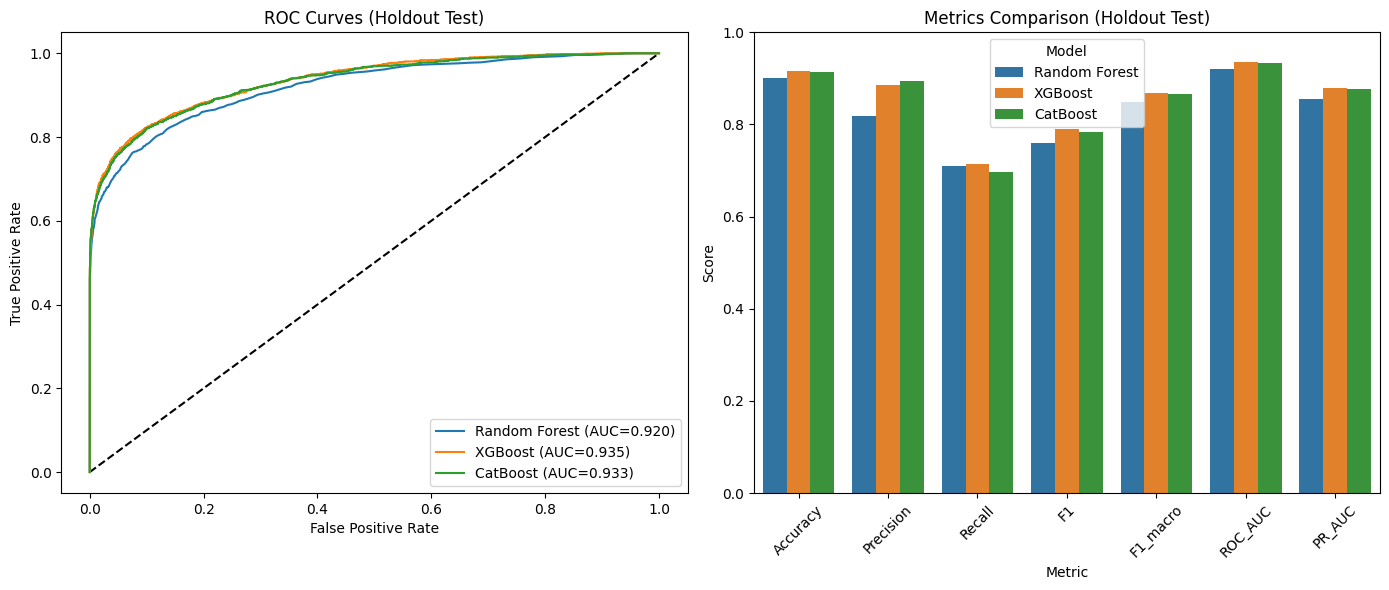

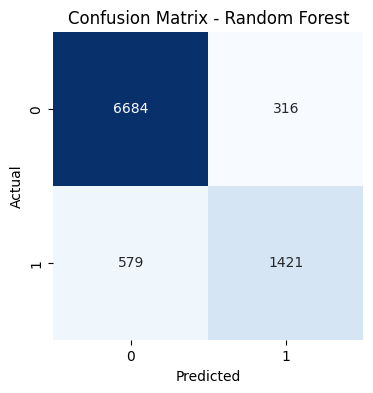

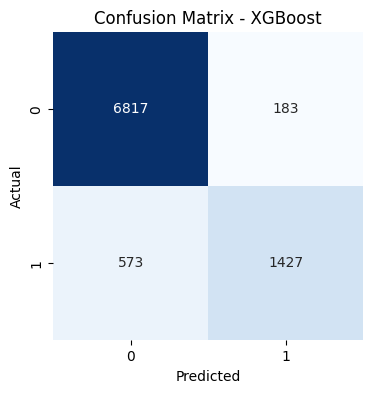

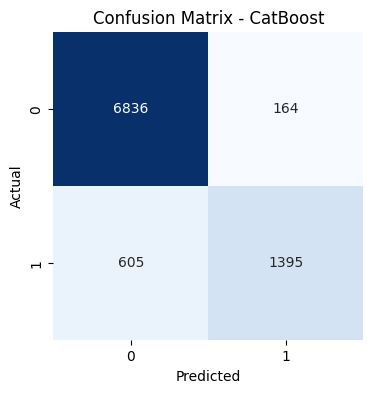

In [31]:
#===========================================
# Validazione holdout con modelli ottimizzati
#===========================================

import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve, confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC

# ===========================
# 1) Load best params
# ===========================
with open("best_params_GS_Pipe.json", "r") as f:
    best_params_all = json.load(f)

def strip_params(params):
    return {k.replace("classifier__", ""): v for k, v in params.items()}

# ===========================
# 2) Rebuild models with best params (settaggi stabili)
# ===========================
rf_best = RandomForestClassifier(
    **strip_params(best_params_all["RandomForest"]),
    random_state=42,
    n_jobs=1,                 # stabilità su Windows
    class_weight="balanced"
)

xgb_best = XGBClassifier(
    **strip_params(best_params_all["XGBoost"]),
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    n_jobs=1                  # evita parallelismo annidato
)

cat_best = CatBoostClassifier(
    **strip_params(best_params_all["CatBoost"]),
    verbose=0,
    random_state=42,
    auto_class_weights="Balanced")
    #thread_count=1      )      # equivalente di n_jobs per CatBoost


models_best = {
    "Random Forest": rf_best,
    "XGBoost": xgb_best,
    "CatBoost": cat_best
}

# ===========================
# 3) SMOTENC: indici categorici coerenti con il preprocessor
# ===========================
preprocessor.fit(X_train)
X_train_transformed = preprocessor.transform(X_train)
cat_indices = [X_train_transformed.columns.get_loc(c) for c in categorical_features]

smote = SMOTENC(categorical_features=cat_indices, random_state=42)

# ===========================
# 4) Train + metriche + ROC
# ===========================
results = []

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.title("ROC Curves (Holdout Test)")
plt.plot([0, 1], [0, 1], "k--")

for name, model in models_best.items():
    pipe = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", smote),
        ("classifier", model)
    ])

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "F1_macro": f1_macro,
        "ROC_AUC": roc_auc,
        "PR_AUC": pr_auc
    })

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# ===========================
# 5) Metrics summary + barplot
# ===========================
df_results = pd.DataFrame(results)
display(df_results)

plt.subplot(1, 2, 2)
metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1", "F1_macro", "ROC_AUC", "PR_AUC"]
df_melt = df_results.melt(id_vars="Model", value_vars=metrics_to_plot, var_name="Metric", value_name="Score")
sns.barplot(x="Metric", y="Score", hue="Model", data=df_melt)
plt.title("Metrics Comparison (Holdout Test)")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# ===========================
# 6) Confusion matrices
# ===========================
for name, model in models_best.items():
    pipe = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", smote),
        ("classifier", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


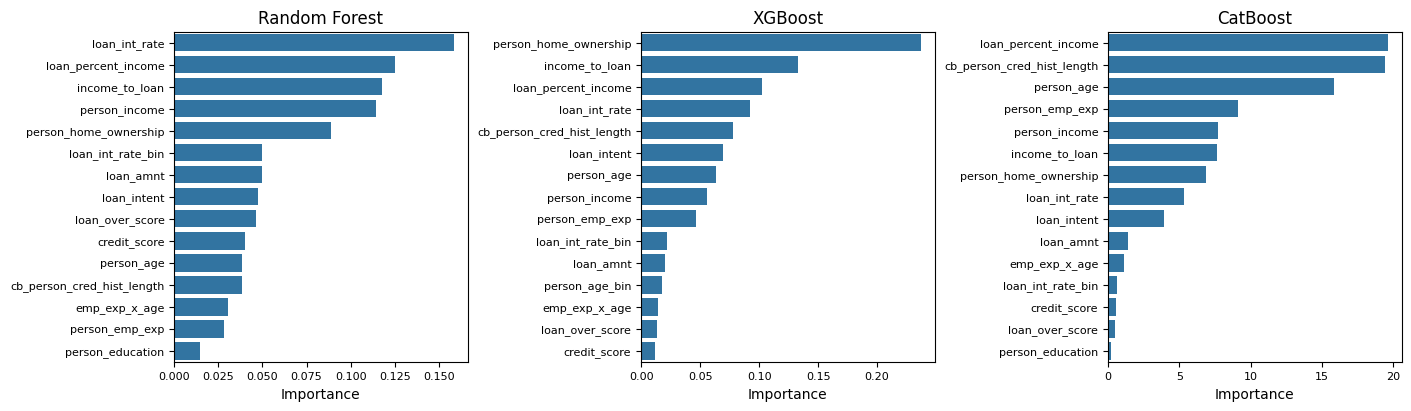

In [33]:
# === Feature Importances (top-N) affiancate per RF, XGB, Cat ===
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC

# 1) indici categorici coerenti con il preprocessor
preprocessor.fit(X_train)
X_train_t = preprocessor.transform(X_train)
cat_indices = [X_train_t.columns.get_loc(c) for c in categorical_features]
smote = SMOTENC(categorical_features=cat_indices, random_state=42)

# 2) ricostruisci i modelli con i best params già trovati (riuso della tua variabile 'best_params_all')
def strip_params(params): 
    return {k.replace("classifier__", ""): v for k, v in params.items()}

rf_best = RandomForestClassifier(**strip_params(best_params_all["RandomForest"]),
                                 random_state=42, n_jobs=1, class_weight="balanced")

xgb_best = XGBClassifier(**strip_params(best_params_all["XGBoost"]),
                         use_label_encoder=False, eval_metric="logloss",
                         random_state=42, n_jobs=1)

cat_best = CatBoostClassifier(**strip_params(best_params_all["CatBoost"]),
                              verbose=0, random_state=42, auto_class_weights="Balanced")
                              #thread_count=1)

models = {
    "Random Forest": rf_best,
    "XGBoost": xgb_best,
    "CatBoost": cat_best
}

# 3) funzione util per estrarre importances in dataframe ordinato
def get_importances_df(clf, feature_names, top_n=12):
    if hasattr(clf, "feature_importances_"):
        imp = clf.feature_importances_
    elif clf.__class__.__name__ == "CatBoostClassifier":
        imp = clf.get_feature_importance()
    else:
        raise ValueError("Il modello non espone feature importances.")
    df = pd.DataFrame({"feature": feature_names, "importance": imp})
    return df.sort_values("importance", ascending=False).head(top_n)

# 4) fit pipeline per ciascun modello e raccolta top-N
top_n = 15 
feat_names = list(X_train_t.columns)  # ordine: numeriche + categoriche

tops = {}
for name, base_model in models.items():
    pipe = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", smote),
        ("classifier", base_model)
    ])
    pipe.fit(X_train, y_train)
    clf = pipe.named_steps["classifier"]
    tops[name] = get_importances_df(clf, feat_names, top_n=top_n)

# 5) plotting side-by-side (grafici piccoli)
fig, axes = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)
for ax, (name, df_imp) in zip(axes, tops.items()):
    sns.barplot(ax=ax, data=df_imp, x="importance", y="feature")
    ax.set_title(name)
    ax.set_xlabel("Importance")
    ax.set_ylabel("")
    # rendi testo piccolo
    ax.tick_params(axis='both', labelsize=8)
plt.show()


SHAP summary — Random Forest


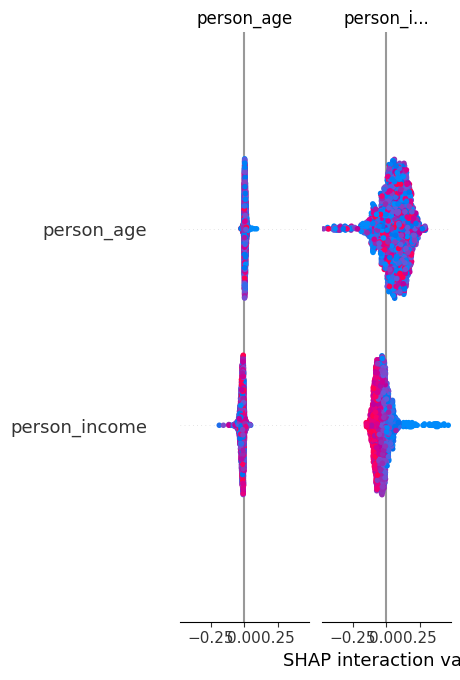

SHAP summary — XGBoost


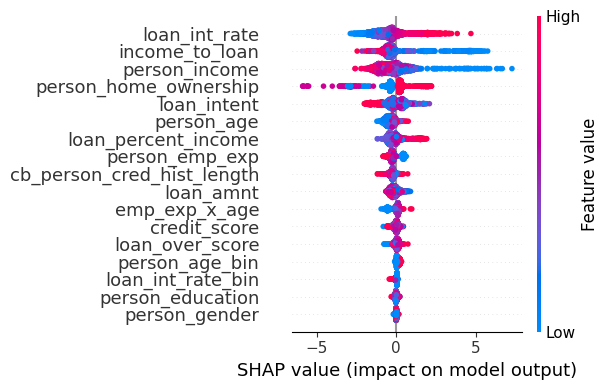

SHAP summary — CatBoost


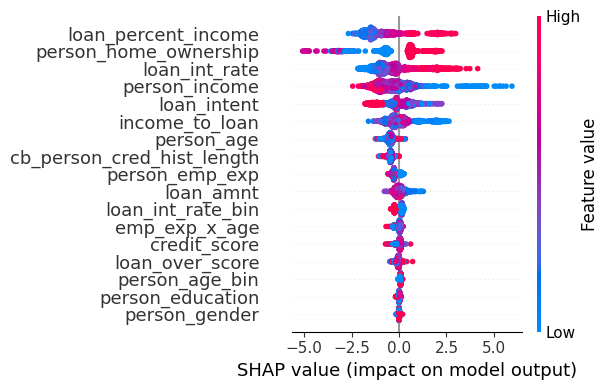

In [35]:
# === SHAP feature importance / summary per RF, XGB, Cat ===
import shap
import numpy as np

# 1) Preprocessing + SMOTENC fuori pipeline (così possiamo passare X al TreeExplainer)
preprocessor.fit(X_train)
X_tr = preprocessor.transform(X_train)
y_tr = y_train.copy()

cat_indices = [X_tr.columns.get_loc(c) for c in categorical_features]
smote = SMOTENC(categorical_features=cat_indices, random_state=42)
X_res, y_res = smote.fit_resample(X_tr, y_tr)

# 2) Fit dei tre modelli standalone (con gli stessi best params)
rf_best = RandomForestClassifier(**strip_params(best_params_all["RandomForest"]),
                                 random_state=42, n_jobs=1, class_weight="balanced")
xgb_best = XGBClassifier(**strip_params(best_params_all["XGBoost"]),
                         use_label_encoder=False, eval_metric="logloss",
                         random_state=42, n_jobs=1)
cat_best = CatBoostClassifier(**strip_params(best_params_all["CatBoost"]),
                              verbose=0, random_state=42, auto_class_weights="Balanced")
                              #thread_count=1)

rf_best.fit(X_res, y_res)
xgb_best.fit(X_res, y_res)
cat_best.fit(X_res, y_res)

# 3) SHAP su un sottoinsieme del test per velocità
X_te = preprocessor.transform(X_test)
max_points = 2000
if len(X_te) > max_points:
    sampler = np.random.choice(len(X_te), size=max_points, replace=False)
    X_shap = X_te.iloc[sampler]
else:
    X_shap = X_te

# 4) summary_plot per ciascun modello (beeswarm)
for name, model in [("Random Forest", rf_best), ("XGBoost", xgb_best), ("CatBoost", cat_best)]:
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(X_shap)
    # per binario, xgboost/catboost spesso restituiscono lista [class0, class1]
    if isinstance(shap_vals, list) and len(shap_vals) == 2:
        shap_vals = shap_vals[1]
    print(f"SHAP summary — {name}")
    shap.summary_plot(shap_vals, X_shap, feature_names=X_shap.columns, show=True, plot_size=(6,4))


In [ ]:



################################# QUESTA RUIVEDILA  ####################################################


"""
import pandas as pd

# Funzione helper per estrarre i risultati migliori
def extract_results(grid, model_name):
    return {
        "Model": model_name,
        "Best Params": grid.best_params_,
        "Best Recall": grid.cv_results_['mean_test_recall'][grid.best_index_],
        "Best Precision": grid.cv_results_['mean_test_precision'][grid.best_index_],
        "Best F1-macro": grid.cv_results_['mean_test_f1_macro'][grid.best_index_],
        "Best ROC_AUC": grid.cv_results_['mean_test_roc_auc'][grid.best_index_]
    }

results = []
results.append(extract_results(rf_grid, "Random Forest"))
results.append(extract_results(xgb_grid, "XGBoost"))
results.append(extract_results(cat_grid, "CatBoost"))

df_results = pd.DataFrame(results)
display(df_results)
"""


# =======================================
# 12) SALVATAGGIO PIPELINE MIGLIORE (JOBLIB)
# =======================================
import joblib, os
out_dir = Path('Models')
out_dir.mkdir(exist_ok=True)
if chosen is not None:
    out_path = out_dir / f'best_pipeline_{chosen_name}.joblib'
    joblib.dump(chosen, out_path)
    print('Salvato:', out_path)
else:
    print('Nessun modello da salvare.')
